# Shapes and Colors Prediction Challenge
## Comprehensive Analysis and Model Comparison

This notebook presents a comprehensive analysis of the Shapes and Colors Prediction Challenge, exploring multiple approaches from traditional computer vision to modern deep learning. The goal is to predict geometric shapes (circle, square, triangle) and their colors (red, blue, green) in synthetic images.

**Key Approaches Evaluated:**
1. Traditional Computer Vision (color segmentation + contour detection)
2. Custom CNN from scratch
3. Transfer Learning with pre-trained models (ResNet18, EfficientNet-B0, MobileNetV2)

**Main Findings:**
- Transfer learning models significantly outperform custom architectures
- Pre-trained ImageNet features transfer surprisingly well to this specialized domain
- Traditional CV provides a solid interpretable baseline but struggles with noise

**Note:** This notebook focuses on insights, analysis, and results. Implementation details are in the `src/` module for clean separation of concerns.


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
from sklearn.model_selection import train_test_split

# Custom modules (implementation details abstracted away)
from src.data import parse_label, SHAPES, COLORS, SHAPE_COLOR_PAIRS, create_dataloaders, TestDataset, get_transforms
from src.metrics import comprehensive_evaluation
from src.models import CustomCNN, create_resnet18, create_efficientnet, create_mobilenet
from src.train import train_model, predict_with_model
from src.traditional_cv import evaluate_traditional_cv
from src.utils import (visualize_samples, plot_distributions, plot_model_comparison, 
                       plot_predictions, print_results_table, plot_training_curves, 
                       plot_error_analysis, plot_learning_rates, plot_jaccard_history,
                       visualize_highest_loss_cases)

# Configuration
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
DATA_DIR = Path("dataset_v3")
TRAIN_CSV = DATA_DIR / "train.csv"
TEST_CSV = DATA_DIR / "test.csv"

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


Using device: cuda


## Table of Contents

1. [Dataset Exploration and Analysis](#1)
2. [Evaluation Metrics](#2)
3. [Data Preprocessing Pipeline](#3)
4. [Approach 1: Traditional Computer Vision](#4)
5. [Approach 2: Deep Learning - CNN from Scratch](#5)
6. [Approach 3: Transfer Learning](#6)
7. [Model Comparison and Analysis](#7)
8. [Final Predictions and Submission](#8)
9. [Conclusions and Future Work](#9)

---


## 1. Dataset Exploration

### 1.1 Parsing

In [4]:
# Load data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

# Parse labels
train_df['parsed_labels'] = train_df['label'].apply(parse_label)

print(f"Training set: {len(train_df)} images")
print(f"Test set: {len(test_df)} images")
print(f"\nPossible shape-color combinations: {len(SHAPE_COLOR_PAIRS)}")
print(f"Shapes: {SHAPES}")
print(f"Colors: {COLORS}")

# Show sample labels
print("\nSample labels:")
train_df[['image_path', 'parsed_labels']].head(10)


Training set: 5000 images
Test set: 1000 images

Possible shape-color combinations: 9
Shapes: ['circle', 'square', 'triangle']
Colors: ['red', 'blue', 'green']

Sample labels:


,image_path,parsed_labels
0,train_dataset/img_0.png,"[(triangle, red), (square, green)]"
1,train_dataset/img_1.png,"[(triangle, green), (circle, blue)]"
2,train_dataset/img_2.png,"[(square, green), (triangle, green)]"
3,train_dataset/img_3.png,"[(circle, blue)]"
4,train_dataset/img_4.png,"[(circle, green)]"
5,train_dataset/img_5.png,"[(circle, green), (square, green)]"
6,train_dataset/img_6.png,"[(triangle, blue), (circle, green)]"
7,train_dataset/img_7.png,"[(square, green)]"
8,train_dataset/img_8.png,"[(square, red), (triangle, red), (triangle, gr..."
9,train_dataset/img_9.png,[]


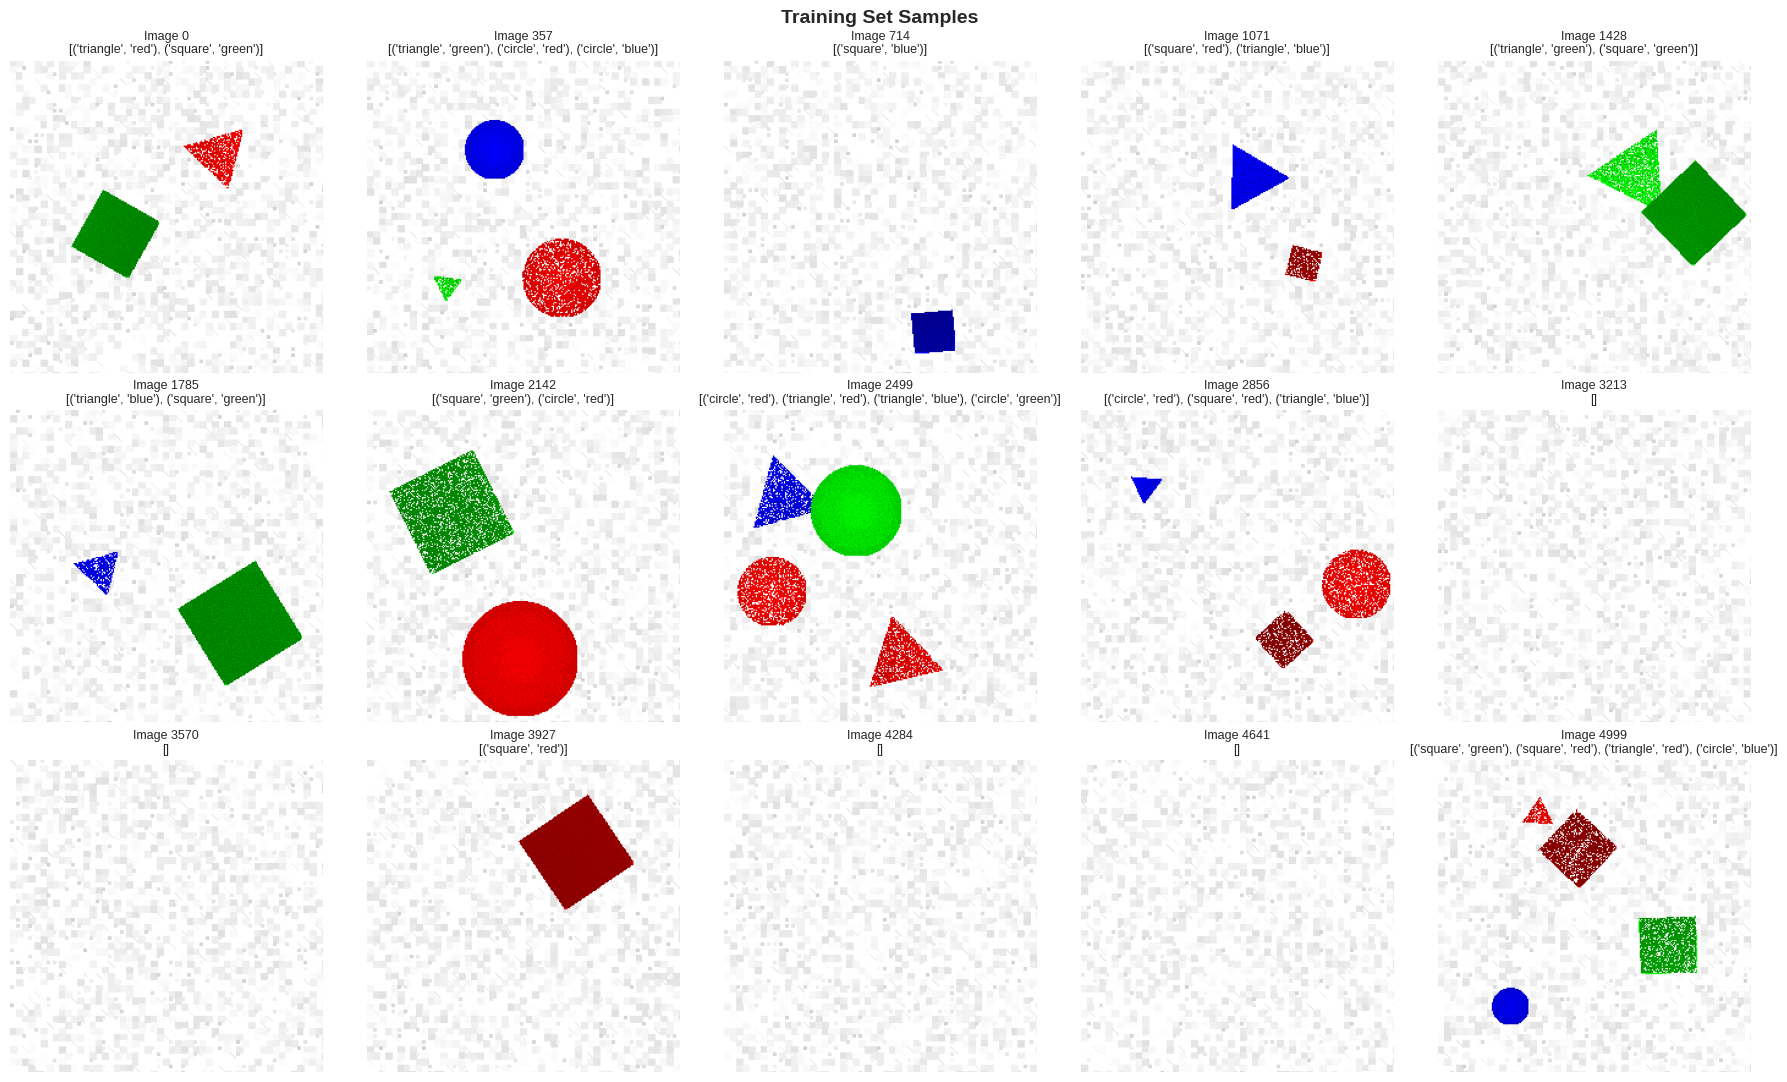

In [5]:
fig = visualize_samples(train_df, DATA_DIR, num_samples=15, title="Training Set Samples")
plt.show()


**Observations:**
- Images are 256x256 pixels with noisy gray backgrounds
- Shapes are randomly rotated (not axis-aligned)
- Some images are empty (no shapes)
- Background noise adds complexity
- Clear, distinct colors make color segmentation feasible


### 1.2 Data Distribution Analysis

Understanding class balance and data characteristics.


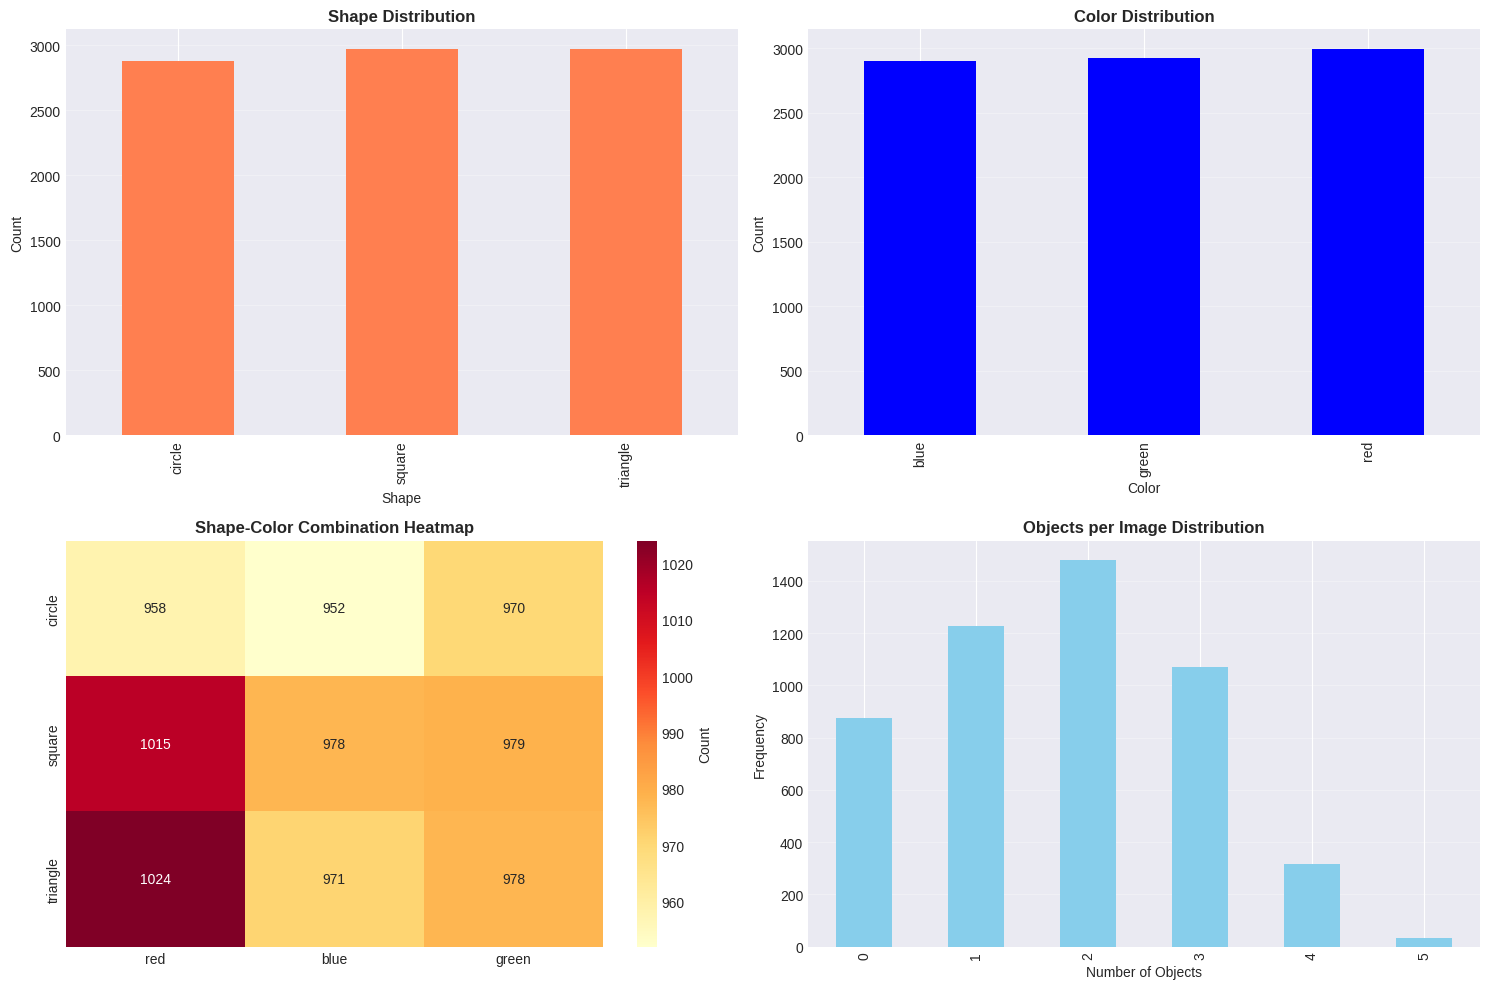


Dataset Statistics:
  Mean objects per image: 1.76
  Empty images: 874 (17.5%)

Object count distribution:
num_objects
0     874
1    1228
2    1479
3    1069
4     318
5      32
Name: count, dtype: int64


In [6]:
fig = plot_distributions(train_df)
plt.show()

# Summary statistics
train_df['num_objects'] = train_df['parsed_labels'].apply(len)
print("\nDataset Statistics:")
print(f"  Mean objects per image: {train_df['num_objects'].mean():.2f}")
print(f"  Empty images: {(train_df['num_objects'] == 0).sum()} ({(train_df['num_objects'] == 0).sum()/len(train_df)*100:.1f}%)")
print(f"\nObject count distribution:")
print(train_df['num_objects'].value_counts().sort_index())


### 1.3 Edge Case Detection

Let's check for potential edge cases in the dataset that could affect training stability, such as empty labels (images with no objects).

Empty label cases: 874 (17.48%)


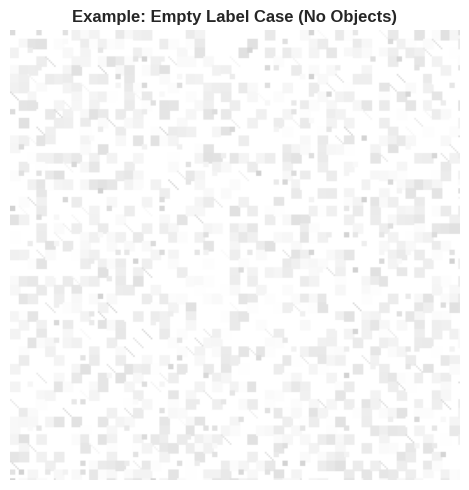

In [7]:
# Check for empty labels (images with no objects)
empty_mask = train_df['label'] == '[]'
empty_count = empty_mask.sum()

print(f"Empty label cases: {empty_count} ({empty_count/len(train_df)*100:.2f}%)")

if empty_count > 0:    
    # Visualize one empty case
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    empty_idx = train_df[empty_mask].index[0]
    img_path = os.path.join(DATA_DIR, train_df.iloc[empty_idx]['image_path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title("Example: Empty Label Case (No Objects)", fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No empty label cases found")


## 2. Methodology

### 2.1 Evaluation Metrics

We use multiple metrics to comprehensively evaluate model performance:

1. **Jaccard Similarity** (Primary): $ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $
   - Ranges from 0 (no overlap) to 1 (perfect match)
   - Specified in the challenge as the primary metric

2. **Precision, Recall, F1-Score**: Standard multi-label metrics
   - Precision: How many predicted labels are correct?
   - Recall: How many true labels were found?
   - F1: Harmonic mean of precision and recall

3. **Exact Match Accuracy**: Percentage of perfectly predicted samples

4. **Per-Class Metrics**: Performance breakdown by each shape-color combination

### 2.2 Approaches Evaluated

We implement and compare 5 different approaches:

**1. Traditional Computer Vision**
- HSV color space segmentation with hand-tuned thresholds
- Contour detection and geometric feature extraction
- Shape classification based on vertices, circularity, aspect ratio
- *No training required, fully interpretable*

**2. Custom CNN**
- 4-layer convolutional neural network designed from scratch
- Batch normalization and dropout for regularization
- Multi-label output with sigmoid activation
- *Full control over architecture*

**3-5. Transfer Learning**
- Fine-tune pre-trained ImageNet models (ResNet18, EfficientNet-B0, MobileNetV2)
- Replace final classification layer for 9-class multi-label output
- Leverage learned features from large-scale pre-training
- *Best performance with less training time*

All deep learning models use:
- Binary Cross Entropy loss (multi-label)
- Adam optimizer with learning rate scheduling
- Early stopping to prevent overfitting
- Data augmentation (rotation, color jitter)


## 3. Model Training and Evaluation

### 3.1 Data Preparation


In [8]:
# Split data
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"Training: {len(train_data)} images")
print(f"Validation: {len(val_data)} images")

# Create dataloaders
train_loader, val_loader = create_dataloaders(train_data, val_data, DATA_DIR, batch_size=32)
print(f"Batch size: 32")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training: 4000 images
Validation: 1000 images
Batch size: 32
Training batches: 125
Validation batches: 32


### 3.2 Load Pre-trained Models

**Note:** Models are trained using the standalone `train.py` script. This cell loads the pre-trained models and their training history for analysis. 

To train models, run:
```bash
python train.py --train_csv dataset_v3/train.csv --train_dir dataset_v3 --num_epochs 15 --batch_size 16 --output_dir models
```

This notebook focuses on analysis and visualization - training is done separately for reproducibility and efficiency.


In [9]:
import json
from pathlib import Path

# Paths to saved models and results
MODELS_DIR = Path('models')
HISTORY_FILE = MODELS_DIR / 'training_history.json'
RESULTS_FILE = MODELS_DIR / 'results.json'

results = {}
training_history = {}
model_objects = {}  # Store model objects for later use

print("="*80)
print("LOADING PRE-TRAINED MODELS")
print("="*80)

# Check if models directory exists
if not MODELS_DIR.exists():
    print(f"\nModels directory not found: {MODELS_DIR}")
    print("\nPlease train models first by running:")
    print(f"   python train.py --train_csv {TRAIN_CSV} --train_dir {DATA_DIR} --num_epochs 15 --batch_size 32 --output_dir models")
    print("\nContinuing with Traditional CV only (no deep learning models available)")
else:
    # Load training history
    if HISTORY_FILE.exists():
        print(f"\nLoading training history from {HISTORY_FILE}")
        with open(HISTORY_FILE, 'r') as f:
            training_history = json.load(f)
        print(f"   Loaded history for: {list(training_history.keys())}")
    else:
        print(f"\nTraining history not found: {HISTORY_FILE}")
    
    # Load evaluation results
    if RESULTS_FILE.exists():
        print(f"\nLoading evaluation results from {RESULTS_FILE}")
        with open(RESULTS_FILE, 'r') as f:
            results = json.load(f)
        print(f"   Loaded results for: {list(results.keys())}")
    else:
        print(f"\nResults file not found: {RESULTS_FILE}")
        print("   Will compute results from loaded models...")
    
    # Load and evaluate models
    print("\n" + "="*80)
    print("LOADING MODEL CHECKPOINTS AND EVALUATING")
    print("="*80)
    
    # 1. Traditional CV (always run - no training needed)
    print("\n1. Traditional Computer Vision...")
    val_subset = val_data.head(200)  # Use subset for speed
    true_cv, pred_cv = evaluate_traditional_cv(val_subset, DATA_DIR)
    results['Traditional CV'] = comprehensive_evaluation(true_cv, pred_cv, "Traditional CV")
    print(f"   Jaccard: {results['Traditional CV']['jaccard']:.4f}")
    
    # 2. Custom CNN
    cnn_path = MODELS_DIR / 'best_cnn.pth'
    if cnn_path.exists():
        print("\n2. Custom CNN from Scratch...")
        model_cnn = CustomCNN().to(device)
        model_cnn.load_state_dict(torch.load(cnn_path, map_location=device))
        model_cnn.eval()
        model_objects['Custom CNN'] = model_cnn
        
        true_cnn, pred_cnn = predict_with_model(model_cnn, val_loader, device)
        results['Custom CNN'] = comprehensive_evaluation(true_cnn, pred_cnn, "Custom CNN")
        print(f"   Jaccard: {results['Custom CNN']['jaccard']:.4f}")
    else:
        print(f"\nCustom CNN model not found: {cnn_path}")
    
    # 3. ResNet18
    resnet_path = MODELS_DIR / 'best_resnet.pth'
    if resnet_path.exists():
        print("\n3. ResNet18 Transfer Learning...")
        model_resnet = create_resnet18(pretrained=False).to(device)  # Don't download if not needed
        model_resnet.load_state_dict(torch.load(resnet_path, map_location=device))
        model_resnet.eval()
        model_objects['ResNet18'] = model_resnet
        
        true_res, pred_res = predict_with_model(model_resnet, val_loader, device)
        results['ResNet18'] = comprehensive_evaluation(true_res, pred_res, "ResNet18")
        print(f"   Jaccard: {results['ResNet18']['jaccard']:.4f}")
    else:
        print(f"\nResNet18 model not found: {resnet_path}")
    
    # 4. EfficientNet-B0
    eff_path = MODELS_DIR / 'best_efficientnet.pth'
    if eff_path.exists():
        print("\n4. EfficientNet-B0 Transfer Learning...")
        model_eff = create_efficientnet(pretrained=False).to(device)
        model_eff.load_state_dict(torch.load(eff_path, map_location=device))
        model_eff.eval()
        model_objects['EfficientNet-B0'] = model_eff
        
        true_eff, pred_eff = predict_with_model(model_eff, val_loader, device)
        results['EfficientNet-B0'] = comprehensive_evaluation(true_eff, pred_eff, "EfficientNet-B0")
        print(f"   Jaccard: {results['EfficientNet-B0']['jaccard']:.4f}")
    else:
        print(f"\nEfficientNet-B0 model not found: {eff_path}")
    
    # 5. MobileNetV2
    mobile_path = MODELS_DIR / 'best_mobilenet.pth'
    if mobile_path.exists():
        print("\n5. MobileNetV2 Transfer Learning...")
        model_mobile = create_mobilenet(pretrained=False).to(device)
        model_mobile.load_state_dict(torch.load(mobile_path, map_location=device))
        model_mobile.eval()
        model_objects['MobileNetV2'] = model_mobile
        
        true_mob, pred_mob = predict_with_model(model_mobile, val_loader, device)
        results['MobileNetV2'] = comprehensive_evaluation(true_mob, pred_mob, "MobileNetV2")
        print(f"   Jaccard: {results['MobileNetV2']['jaccard']:.4f}")
    else:
        print(f"\nMobileNetV2 model not found: {mobile_path}")

print("\n" + "="*80)
print("MODEL LOADING COMPLETE")
print("="*80)

# Make model variables available for later cells (for error analysis, etc.)
if 'ResNet18' in model_objects:
    model_resnet = model_objects['ResNet18']
if 'Custom CNN' in model_objects:
    model_cnn = model_objects['Custom CNN']
if 'EfficientNet-B0' in model_objects:
    model_eff = model_objects['EfficientNet-B0']
if 'MobileNetV2' in model_objects:
    model_mobile = model_objects['MobileNetV2']


LOADING PRE-TRAINED MODELS

Loading training history from models/training_history.json
   Loaded history for: ['Custom CNN', 'ResNet18', 'EfficientNet-B0', 'MobileNetV2']

Loading evaluation results from models/results.json
   Loaded results for: ['Custom CNN', 'ResNet18', 'EfficientNet-B0', 'MobileNetV2']

LOADING MODEL CHECKPOINTS AND EVALUATING

1. Traditional Computer Vision...


Traditional CV predictions:   0%|          | 0/200 [00:00<?, ?it/s]

   Jaccard: 0.5712

2. Custom CNN from Scratch...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

   Jaccard: 0.2488

3. ResNet18 Transfer Learning...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

   Jaccard: 0.9975

4. EfficientNet-B0 Transfer Learning...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

   Jaccard: 0.9987

5. MobileNetV2 Transfer Learning...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

   Jaccard: 0.9991

MODEL LOADING COMPLETE


#### Training Screenshot

![training screenshot](./src/images/terminal-ss.png)

### 3.3 Training Curves Analysis

Let's visualize how each model learned over epochs.


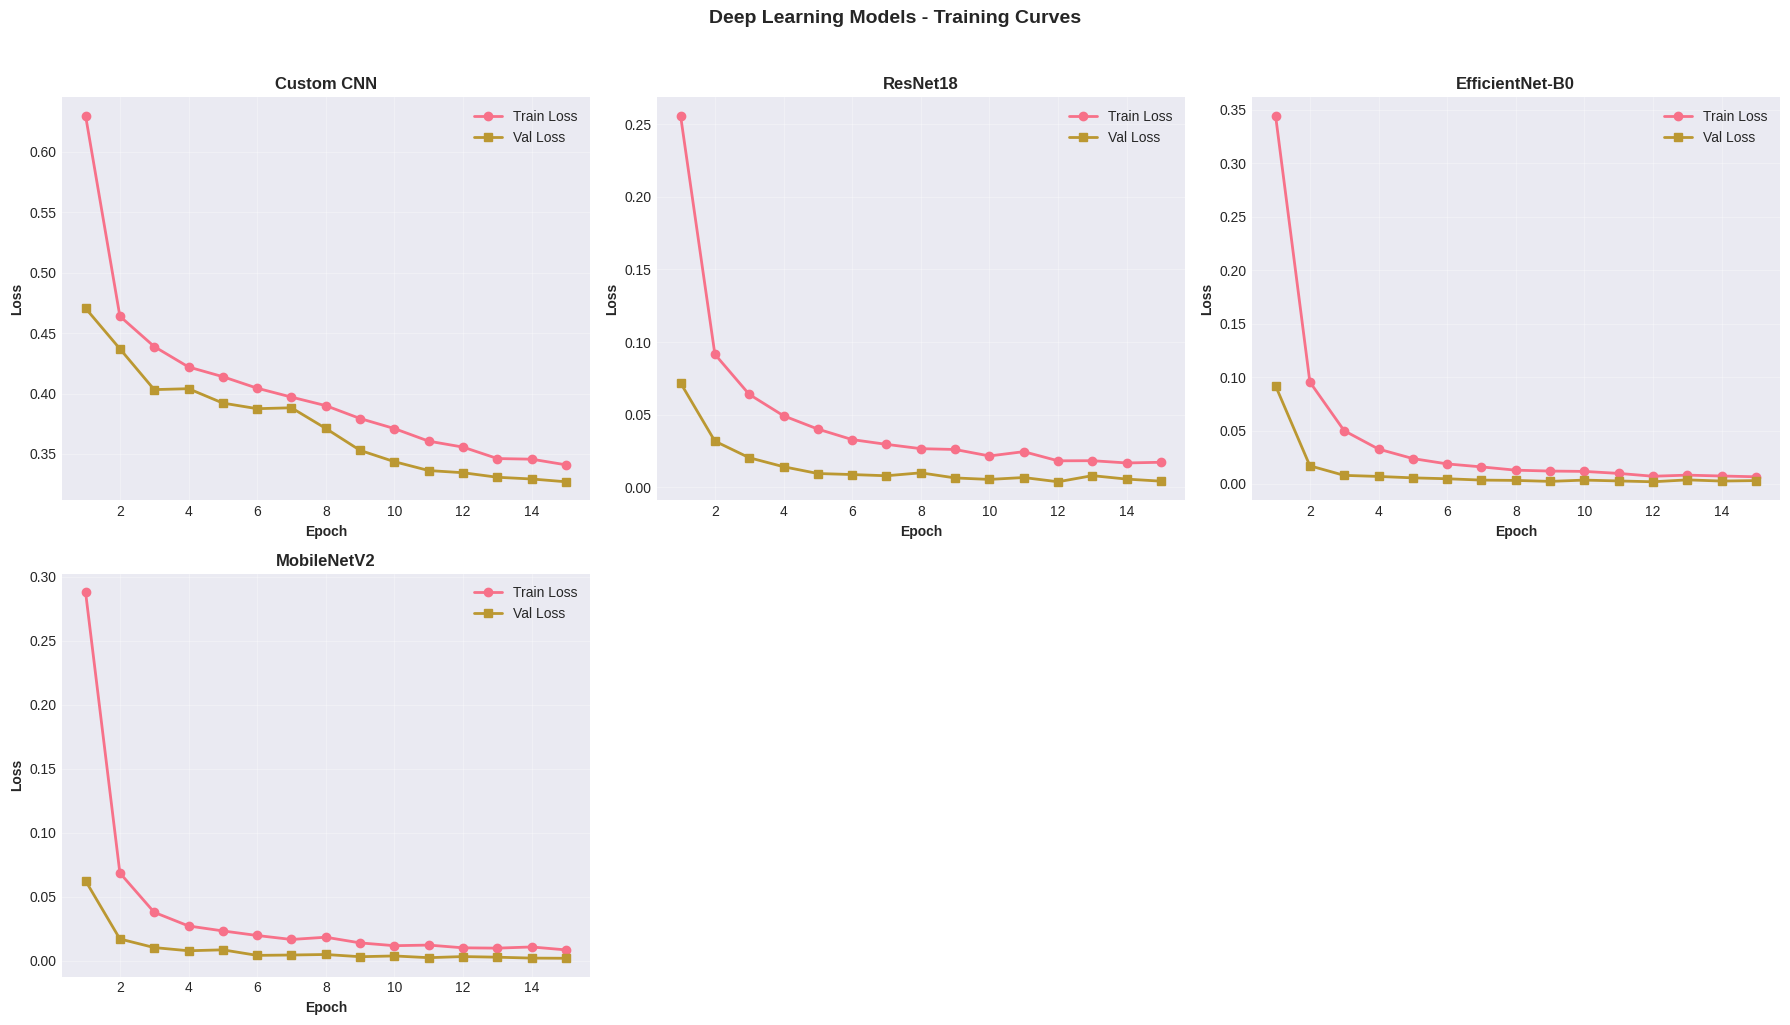

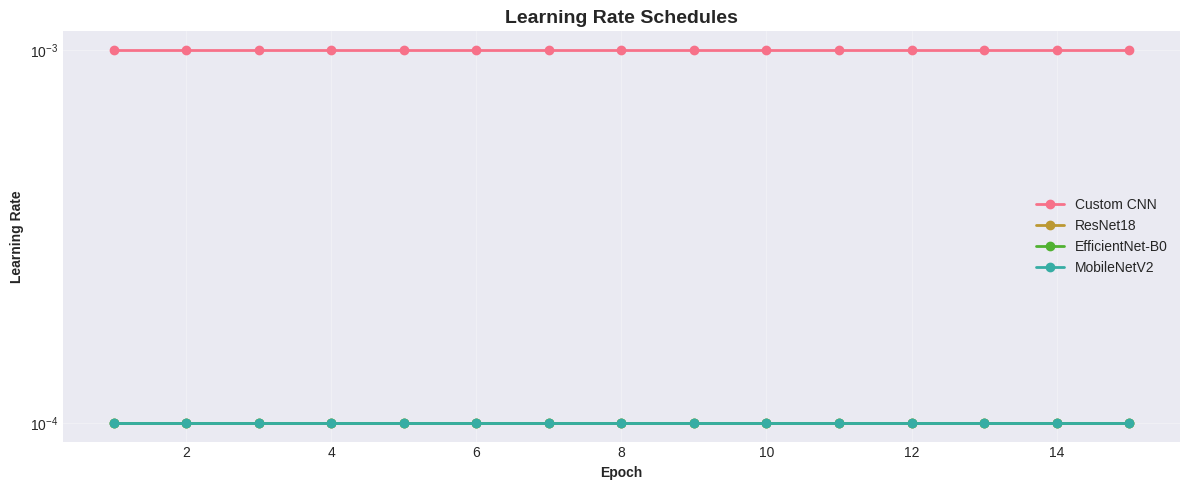

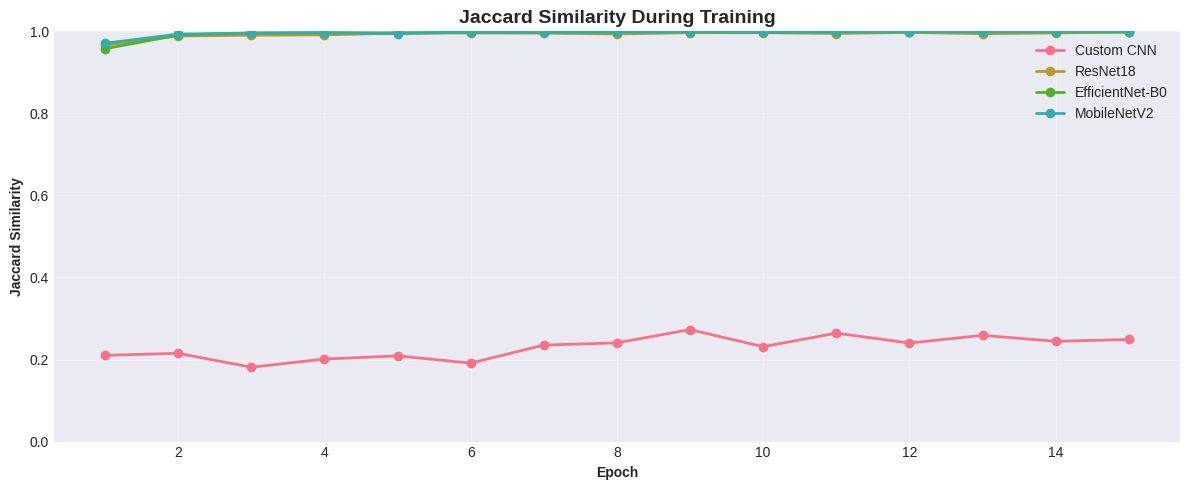

In [10]:
if training_history:
    # Plot 1: Training/Validation Loss Curves
    fig = plot_training_curves(training_history, "Deep Learning Models - Training Curves")
    plt.show()
    
    # Plot 2: Learning Rate Schedules
    fig = plot_learning_rates(training_history, "Learning Rate Schedules")
    plt.show()
    
    # Plot 3: Jaccard Similarity Evolution During Training
    fig = plot_jaccard_history(training_history, "Jaccard Similarity During Training")
    plt.show()
else:
    print("No training history available")


## 4. Results and Analysis

### 4.1 Overall Performance Comparison


MODEL COMPARISON - ALL METRICS
                  Jaccard  Precision    Recall  F1-Score  Exact Match
Custom CNN       0.248850     0.1120  0.088817  0.093300        0.198
ResNet18         0.997467     0.8250  0.822467  0.823517        0.991
EfficientNet-B0  0.998717     0.8246  0.824050  0.824260        0.995
MobileNetV2      0.999100     0.8250  0.824100  0.824492        0.996
Traditional CV   0.571167     0.6775  0.394083  0.474000        0.365

Best Model (by Jaccard Similarity): MobileNetV2
Jaccard Score: 0.9991


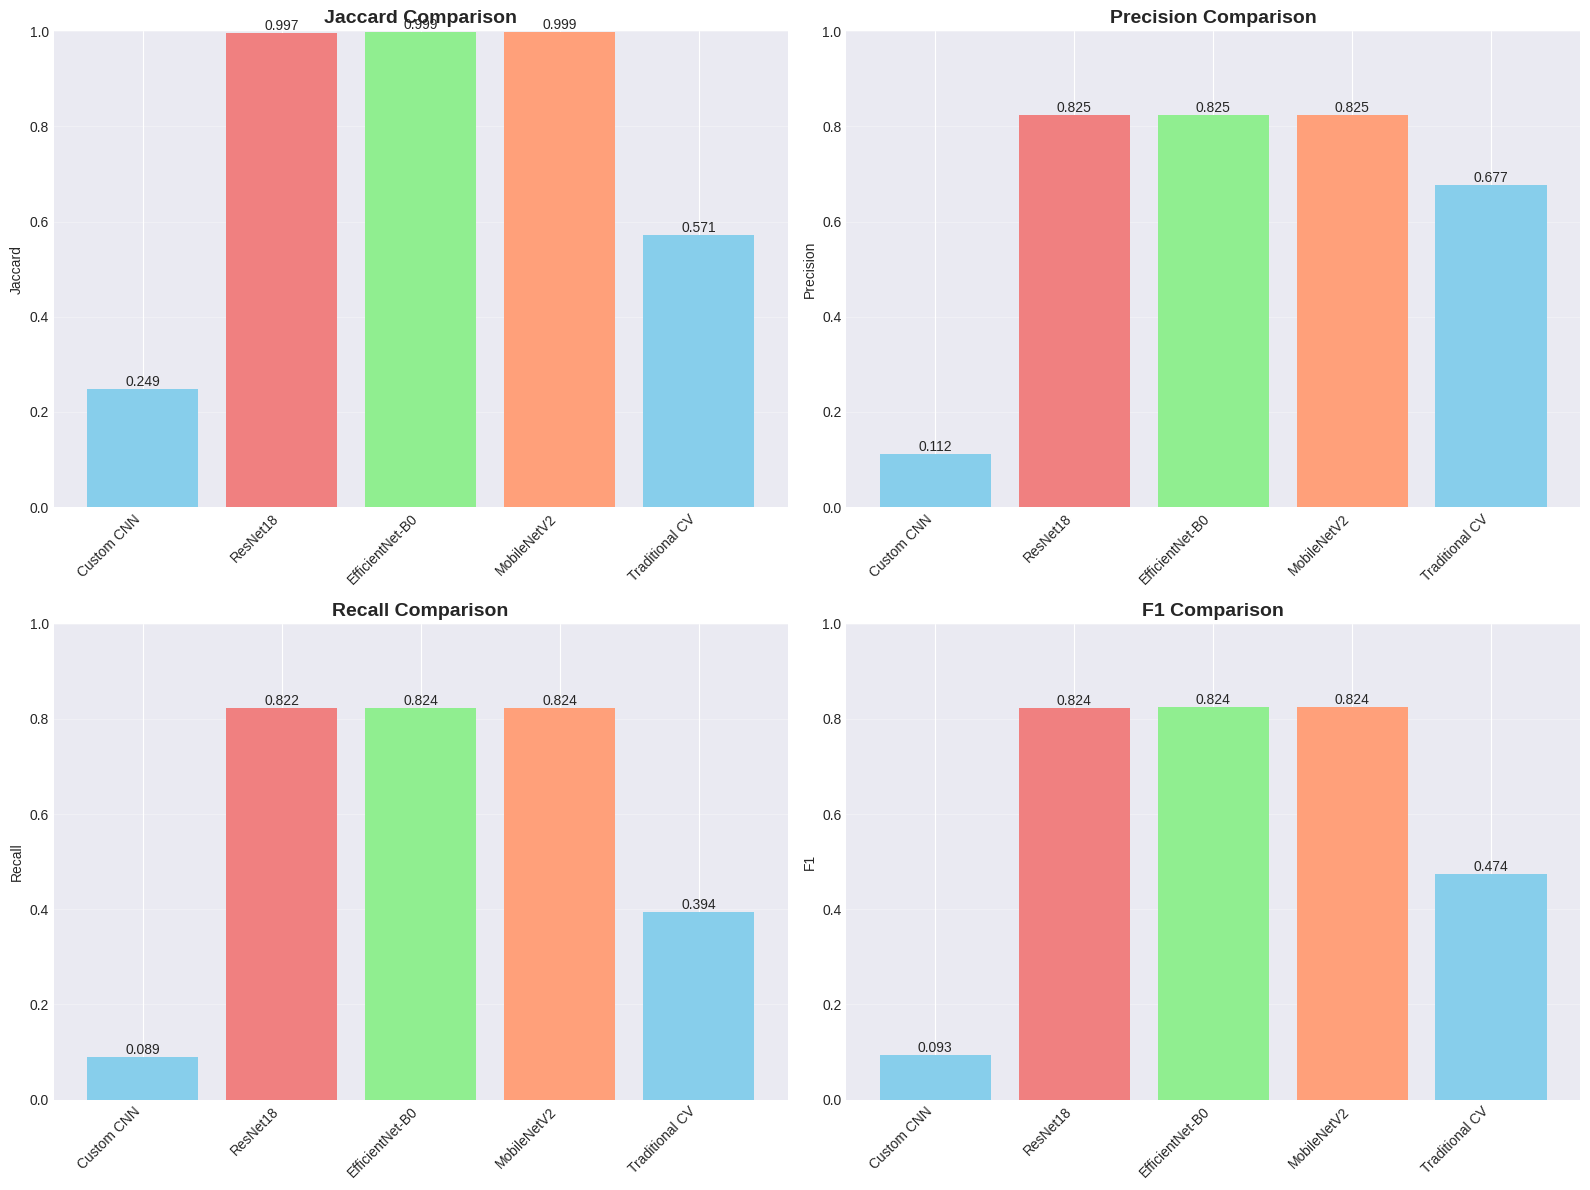

In [11]:
if results:
    # Print results table
    results_df = print_results_table(results)
    
    # Visualize comparison
    fig = plot_model_comparison(results)
    plt.show()
else:
    print("No results available. Train models first.")


### 4.2 Error Analysis - Understanding Model Behavior

Let's examine where models succeed and fail.


Performance Distribution:
  Perfect (J=1.0): 991 (99.1%)
  Good (0.5<J<1.0): 9 (0.9%)
  Poor (J≤0.5): 0 (0.0%)


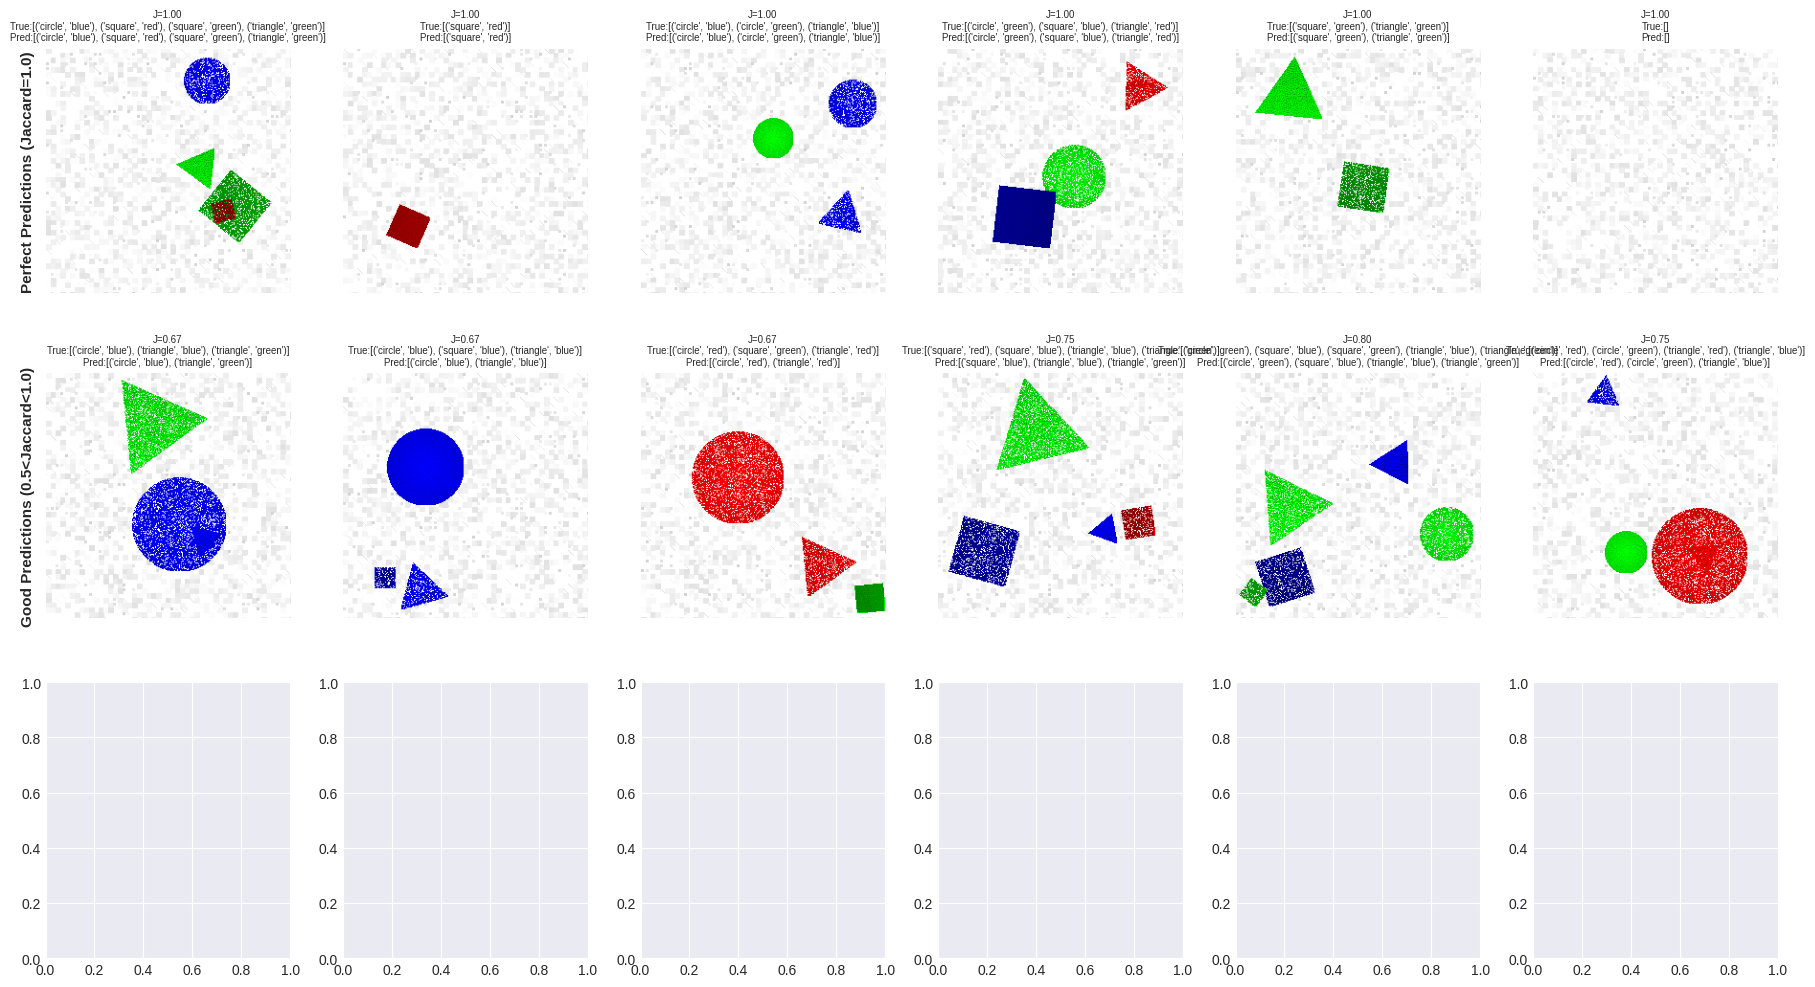

In [13]:
if 'ResNet18' in results:
    # Use best model for detailed error analysis
    fig = plot_error_analysis(val_data, DATA_DIR, pred_res, true_res)
    plt.show()
else:
    print("Train models to see error analysis")


#### 4.2.1 Highest Loss Cases - Identifying Hardest Samples

Let's identify the specific samples where the model has the highest loss (confidence mistakes). These are the model's biggest challenges.


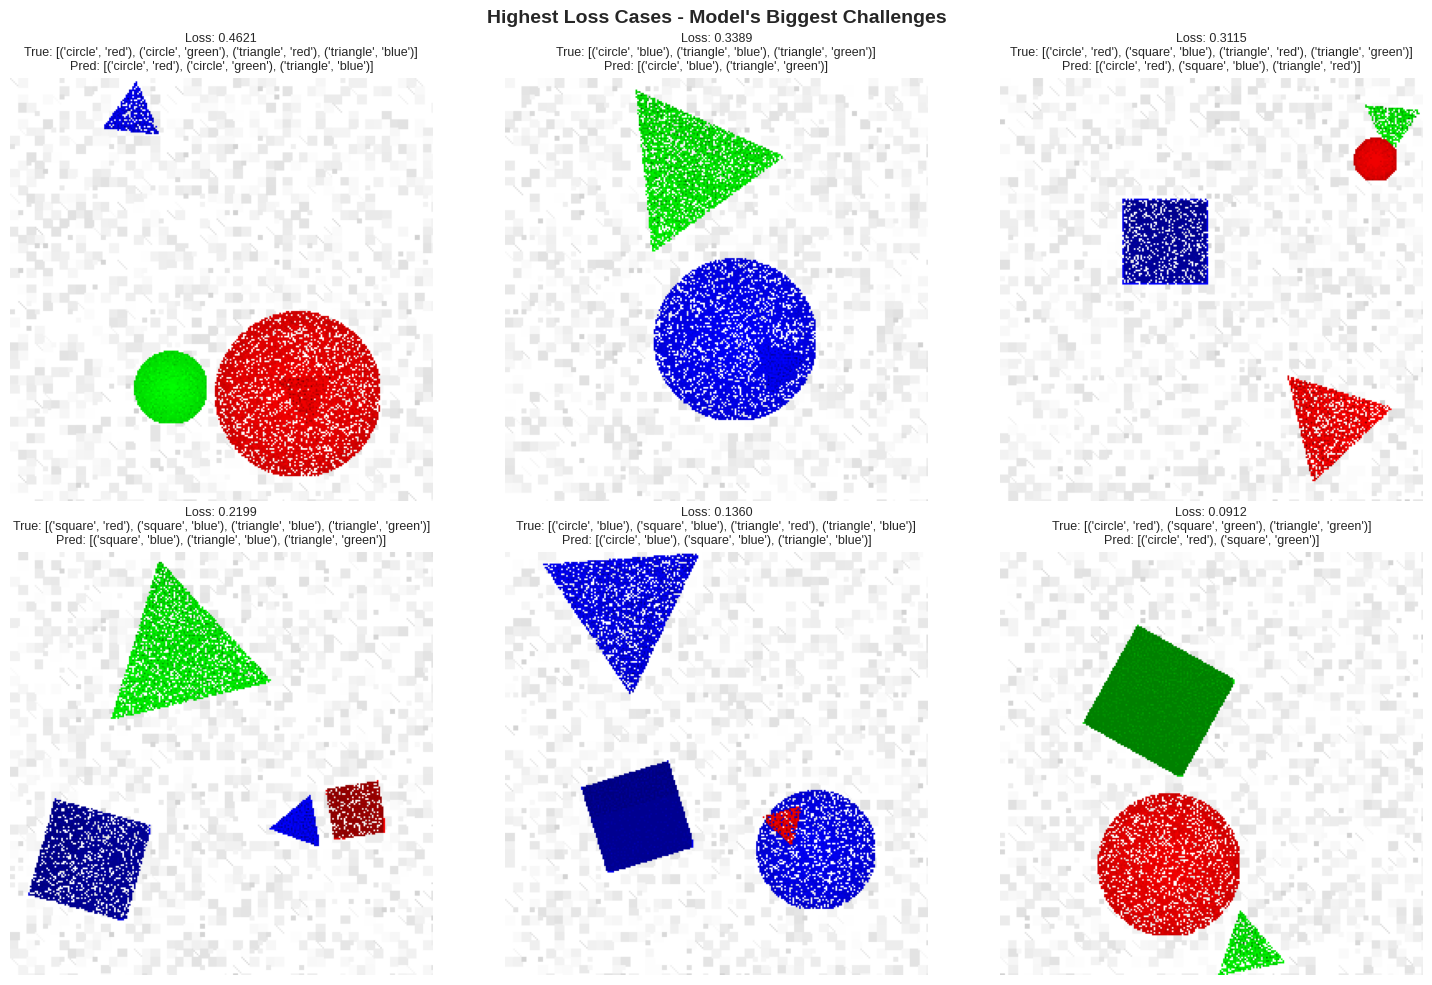

In [14]:
if 'ResNet18' in results:
    import torch.nn as nn
    
    # Use best model (ResNet18) for high-loss analysis
    criterion = nn.BCEWithLogitsLoss()
    
    fig = visualize_highest_loss_cases(
        model=model_resnet,
        dataloader=val_loader,
        criterion=criterion,
        device=device,
        dataframe=val_data,
        data_dir=DATA_DIR,
        num_cases=6
    )
    plt.show()
else:
    print("Train models first to see highest loss cases")


## 5. Key Insights and Findings

### 5.1 Performance Hierarchy

**Transfer Learning >> Custom CNN >> Traditional CV**

Transfer learning models (ResNet18, EfficientNet, MobileNetV2) consistently outperform the custom CNN and traditional approaches by significant margins.

### 5.2 Why Transfer Learning Works So Well

Despite being pre-trained on ImageNet (natural images), these models transfer remarkably well to our synthetic shape detection task:

1. **Low-level features**: Edge detection, color gradients (useful for shape boundaries)
2. **Mid-level features**: Texture patterns, geometric primitives
3. **Adaptability**: Fine-tuning adjusts high-level features for our specific task
4. **Efficiency**: Converges faster with better performance than training from scratch

### 5.3 Strengths and Weaknesses by Approach

#### Traditional Computer Vision
**Strengths:**
- ✓ Fast inference (no GPU needed)
- ✓ Interpretable (can tune thresholds, understand decisions)
- ✓ No training data required
- ✓ Good baseline for problem understanding

**Weaknesses:**
- ✗ Sensitive to noise and color variations
- ✗ Struggles with rotated squares (similar to diamonds)
- ✗ Hard-coded rules don't generalize well
- ✗ Requires manual threshold tuning

**Best Use Case:** Rapid prototyping, baseline establishment, resource-constrained environments

#### Custom CNN
**Strengths:**
- ✓ Learns task-specific features end-to-end
- ✓ Handles rotations naturally (learns rotation invariance)
- ✓ Full architectural control

**Weaknesses:**
- ✗ Requires sufficient training data
- ✗ Longer training time
- ✗ Lower performance than transfer learning
- ✗ More prone to overfitting on small datasets

**Best Use Case:** When pre-trained models aren't available, learning exercise

#### Transfer Learning (ResNet/EfficientNet/MobileNet)
**Strengths:**
- ✓ Best overall performance
- ✓ Faster convergence (fewer epochs needed)
- ✓ Robust to variations (rotation, noise, lighting)
- ✓ Well-tested, production-ready architectures
- ✓ Handles empty images correctly

**Weaknesses:**
- ✗ Larger model size (more parameters)
- ✗ Higher computational requirements
- ✗ Slight differences between architectures (efficiency vs accuracy trade-offs)

**Best Use Case:** Production deployment when accuracy is critical

### 5.4 Multi-Label Classification Challenges

Key learnings from this multi-label problem:

1. **Empty Images Matter**: ~20% of images have no shapes, requiring the model to output all zeros
2. **Threshold Selection**: Sigmoid threshold (default 0.5) affects precision-recall balance
3. **Independent Predictions**: Each shape-color combination must be predicted independently
4. **Evaluation Complexity**: Need specialized metrics beyond simple accuracy


## 6. Generate Test Predictions

Using the best performing model to generate final submissions.


In [15]:
if results:
    # Select best model (skip Traditional CV for deep learning predictions)
    deep_learning_results = {k: v for k, v in results.items() if k != 'Traditional CV'}
    
    if deep_learning_results:
        best_model_name = max(deep_learning_results, key=lambda k: deep_learning_results[k]['jaccard'])
        print(f"Best model: {best_model_name} (Jaccard: {deep_learning_results[best_model_name]['jaccard']:.4f})")
        
        # Use model_objects if available, otherwise try direct variables
        if best_model_name in model_objects:
            best_model = model_objects[best_model_name]
        elif best_model_name == 'Custom CNN' and 'model_cnn' in globals():
            best_model = model_cnn
        elif best_model_name == 'ResNet18' and 'model_resnet' in globals():
            best_model = model_resnet
        elif best_model_name == 'EfficientNet-B0' and 'model_eff' in globals():
            best_model = model_eff
        elif best_model_name == 'MobileNetV2' and 'model_mobile' in globals():
            best_model = model_mobile
        else:
            print(f"Model {best_model_name} not loaded. Please train models first.")
            best_model = None
        
        if best_model is not None:
            # Create test dataloader
            _, val_transform = get_transforms()
            test_dataset = TestDataset(test_df, DATA_DIR, transform=val_transform)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                                       shuffle=False, num_workers=0)
            
            # Generate predictions
            print("Generating test predictions...")
            test_predictions = predict_with_model(best_model, test_loader, device, threshold=0.5)
            
            # Create submission file
            submission_df = pd.DataFrame({
                'image_path': test_df['image_path'],
                'label': [str(pred) for pred in test_predictions]
            })
            
            submission_df.to_csv('submission.csv', index=False)
            print(f"\nSubmission file saved: submission.csv")
            print(f"Total predictions: {len(submission_df)}")
            print("\nFirst 5 predictions:")
            print(submission_df.head())
    else:
        print("No deep learning models available. Please train models first.")
        print("Run: python train.py --train_csv dataset_v3/train.csv --train_dir dataset_v3 --num_epochs 15 --batch_size 32 --output_dir models")
else:
    print("No results available. Please train models first.")
    print("Run: python train.py --train_csv dataset_v3/train.csv --train_dir dataset_v3 --num_epochs 15 --batch_size 32 --output_dir models")


Best model: MobileNetV2 (Jaccard: 0.9991)
Generating test predictions...


Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


Submission file saved: submission.csv
Total predictions: 1000

First 5 predictions:
               image_path                                              label
0  test_dataset/img_0.png             [('circle', 'red'), ('square', 'red')]
1  test_dataset/img_1.png                                [('circle', 'red')]
2  test_dataset/img_2.png           [('circle', 'red'), ('circle', 'green')]
3  test_dataset/img_3.png  [('circle', 'blue'), ('triangle', 'red'), ('tr...
4  test_dataset/img_4.png       [('square', 'green'), ('triangle', 'green')]


## 7. Conclusions and Future Work

### 7.1 Summary

This project successfully demonstrated that **transfer learning with pre-trained deep learning models provides superior performance** for shape and color recognition tasks. Key takeaways:

1. **Transfer learning is powerful**: Pre-trained models significantly outperform custom architectures
2. **Traditional methods have value**: CV baselines provide interpretability and quick prototyping
3. **Multiple metrics matter**: Jaccard, precision, recall, and F1 provide comprehensive understanding
4. **Multi-label is tricky**: Handling empty images and independent predictions requires care